In [2]:
import numpy as np
import matplotlib.pyplot as plt
# %load_ext snakeviz
%load_ext cython

In [3]:
%%cython
def build_faces(long [:,:] tetras, long [:,:] faces, long [:,:] face_tetra):
    cdef int i, j, k, l, n
    cdef int fc = 0
    cdef int ntetra = tetras.shape[0]
    for i in range(ntetra):
        for j in range(i+1,ntetra):
            n = 0
            for k in range(4):
                for l in range(4):
                    if tetras[i,k] == tetras[j,l]:
                        faces[fc,n] = tetras[i,k]
                        face_tetra[fc,0] = i
                        face_tetra[fc,1] = j
                        n+=1

            if n==3:
                fc+=1
                continue
    return fc

def build_neighbours(long [:,:] tetras, long [:,:] neighbours):
    cdef int i, j, k, l, n, nn
    cdef int ntetra = tetras.shape[0]
    for i in range(ntetra):
        nn = 0
        for j in range(ntetra):
            if j == i:
                continue
            n = 0
            for k in range(4):
                for l in range(4):
                    if tetras[i,k] == tetras[j,l]:
                        n+=1
            if n==3:
                neighbours[i,nn] = j
#                 print('n==3',i,nn,j)
                nn+=1
            if nn == 4:
#                 print('nn==3',i,j,n,nn)
                break
            if n == 2:
                continue

            
    return

In [4]:
class TetMesh:
    def __init__(self,origin,nsteps,step_vector):
        self.origin = np.array(origin) 
        self.step_vector = np.array(step_vector)     
        self.nsteps = np.array(nsteps)
        self.nsteps_cells = self.nsteps - 1
        self.n_cell_x = self.nsteps[0] - 1
        self.n_cell_y = self.nsteps[1] - 1
        self.n_cell_z = self.nsteps[2] - 1
        self.n_cells = self.n_cell_x*self.n_cell_y*self.n_cell_z
        self.tetra_mask = np.array([
                      [0,6,5,4],
                      [0,4,5,3],
                      [4,6,7,5],
                      [0,1,6,4],
                      [0,6,5,2]])
        self.tetra_mask_even = np.array([
                        [1,2,3,7],
                        [1,6,7,2],
                        [0,1,2,3],
                        [3,7,5,2],
                        [1,7,3,4]   ])
        
        
        self.ntetra = self.n_cells*5
    def get_tetra(self,pos):
        pos = np.array(pos)
        # initialise array for tetrahedron vertices
        points = np.zeros((5, 4, pos.shape[0], 3))
        points[:] = np.nan
        
        # get cell indexes
        c_xi, c_yi, c_zi = self.position_to_cell_index(pos)

        # determine if using +ve or -ve mask
        even_mask = (c_xi + c_yi+c_zi) % 2 == 0
        # get cell corners
        xi,yi,zi = self.cell_corner_indexes(c_xi,c_yi,c_zi)#global_index_to_node_index(gi)
        # convert to node locations
        nodes = self.node_indexes_to_position(xi,yi,zi).T
        
        points[:,:,even_mask,:]=nodes[:,even_mask,:][self.tetra_mask_even,:,:]
        points[:,:,~even_mask,:]=nodes[:,~even_mask,:][self.tetra_mask,:,:]
        # changing order to points, tetra, nodes, coord
        points = points.swapaxes(0,2)
        points = points.swapaxes(1,2)

        # use scalar triple product to calculate barycentric coords
        vap = pos[:,None,:] - points[:,:, 0,:]
        vbp = pos[:,None,:] - points[:,:, 1, :]
        #         # vcp = p - points[:, 2, :]
        #         # vdp = p - points[:, 3, :]
        vab = points[:,:,  1, :] - points[ :,:, 0, :]
        vac = points[:,:,  2, :] - points[ :,:, 0, :]
        vad = points[:,:,  3, :] - points[ :,:, 0, :]
        vbc = points[:,:,  2, :] - points[:, :, 1, :]
        vbd = points[:,:,  3, :] - points[:, :, 1, :]
        va = np.einsum('ikj, ikj->ik', vbp, np.cross(vbd, vbc, axisa=2, axisb=2)) / 6.
        vb = np.einsum('ikj, ikj->ik', vap, np.cross(vac, vad, axisa=2, axisb=2)) / 6.
        vc = np.einsum('ikj, ikj->ik', vap, np.cross(vad, vab, axisa=2, axisb=2)) / 6.
        vd = np.einsum('ikj, ikj->ik', vap, np.cross(vab, vac, axisa=2, axisb=2)) / 6.
        v = np.einsum('ikj, ikj->ik', vab, np.cross(vac, vad, axisa=2, axisb=2)) / 6.
        
        c = np.zeros((va.shape[0],va.shape[1],4))
            #print(va.shape)
        c[:,:,0] = va / v
        c[:,:,1] = vb / v
        c[:,:,2] = vc / v
        c[:,:,3] = vd / v
        
        # if all coords are +ve then point is inside cell
        mask = np.all(c > 0,axis=2)
        return points[mask,:,:], c[mask]

    def calc_bary_centre(self,points,position):

        npts = len(e)
        vap = position - points[:, 0, :]
        vbp = position - points[:, 1, :]
        # vcp = p - points[:, 2, :]
        # vdp = p - points[:, 3, :]
        vab = points[:, 1, :] - points[:, 0, :]
        vac = points[:, 2, :] - points[:, 0, :]
        vad = points[:, 3, :] - points[:, 0, :]
        vbc = points[:, 2, :] - points[:, 1, :]
        vbd = points[:, 3, :] - points[:, 1, :]
        vbp * np.cross(vbd, vbc, axisa=1, axisb=1)
        va = np.sum(vbp * np.cross(vbd, vbc, axisa=1, axisb=1), axis=1) / 6.
        vb = np.sum(vap * np.cross(vac, vad, axisa=1, axisb=1), axis=1) / 6.
        vc = np.sum(vap * np.cross(vad, vab, axisa=1, axisb=1), axis=1) / 6.
        vd = np.sum(vap * np.cross(vab, vac, axisa=1, axisb=1), axis=1) / 6.
        v = np.sum(vab * np.cross(vac, vad, axisa=1, axisb=1), axis=1) / 6.
        c = np.zeros((4, npts))
        c[0, :] = va / v
        c[1, :] = vb / v
        c[2, :] = vc / v
        c[3, :] = vd / v
        return c
    
    
    def inside(self, pos):

        # check whether point is inside box
        inside = np.ones(pos.shape[0]).astype(bool)
        for i in range(3):
            inside *= pos[:, i] > self.origin[None, i]
            inside *= pos[:, i] < self.origin[None, i] + \
                      self.step_vector[None, i] * self.nsteps_cells[None, i]
        return inside    
    def global_node_indicies(self,indexes):
        indexes = np.array(indexes).swapaxes(0, 2)
        return indexes[:, :, 0] + self.nsteps[None, None, 0] \
                * indexes[:, :,1] + self.nsteps[None, None, 0] * \
                self.nsteps[None, None, 1] * indexes[:, :, 2]
    
    def global_cell_indicies(self,indexes):
        indexes = np.array(indexes).swapaxes(0, 2)
        return indexes[:, :, 0] + self.nsteps_cells[None, None, 0] \
                * indexes[:, :,1] + self.nsteps_cells[None, None, 0] * \
                self.nsteps_cells[None, None, 1] * indexes[:, :, 2]
    def cell_corner_indexes(self, x_cell_index, y_cell_index, z_cell_index):
        """
        Returns the indexes of the corners of a cell given its location xi,
        yi, zi

        Parameters
        ----------
        x_cell_index
        y_cell_index
        z_cell_index

        Returns
        -------

        """
        x_cell_index = np.array(x_cell_index)
        y_cell_index = np.array(y_cell_index)
        z_cell_index = np.array(z_cell_index)
        
        xcorner = np.array([0, 1, 0, 0, 1, 0, 1, 1])
        ycorner = np.array([0, 0, 1, 0, 0, 1, 1, 1])
        zcorner = np.array([0, 0, 0, 1, 1, 1, 0, 1])
        xcorners = x_cell_index[:, None] + xcorner[None, :]
        ycorners = y_cell_index[:, None] + ycorner[None, :]
        zcorners = z_cell_index[:, None] + zcorner[None, :]
        return xcorners, ycorners, zcorners
    
    def position_to_cell_corners(self,pos):
        inside = self.inside(pos)
        ix, iy, iz = self.position_to_cell_index(pos)
        cornersx, cornersy, cornersz = self.cell_corner_indexes(ix, iy, iz)
        globalidx = self.global_cell_indicies(
            np.dstack([cornersx, cornersy, cornersz]).T)
        return globalidx, inside
    
    def position_to_cell_index(self,pos):
        ix = pos[:, 0] - self.origin[None, 0]
        iy = pos[:, 1] - self.origin[None, 1]
        iz = pos[:, 2] - self.origin[None, 2]
        ix = ix // self.step_vector[None, 0]
        iy = iy // self.step_vector[None, 1]
        iz = iz // self.step_vector[None, 2]
        return ix.astype(int), iy.astype(int), iz.astype(int)
    
    def node_indexes_to_position(self, xindex, yindex, zindex):

        x = self.origin[0] + self.step_vector[0] * xindex
        y = self.origin[1] + self.step_vector[1] * yindex
        z = self.origin[2] + self.step_vector[2] * zindex

        return np.array([x, y, z])
    
    def global_index_to_node_index(self, global_index):
        """
        Convert from global indexes to xi,yi,zi

        Parameters
        ----------
        global_index

        Returns
        -------

        """
        # determine the ijk indices for the global index.
        # remainder when dividing by nx = i
        # remained when dividing modulus of nx by ny is j
        print('this')
        x_index = global_index % self.nsteps[0, None]
        y_index = global_index // self.nsteps[0, None] % \
                  self.nsteps[1, None]
        z_index = global_index // self.nsteps[0, None] // \
                  self.nsteps[1, None]
        return x_index, y_index, z_index
    
    def global_index_to_cell_index(self, global_index):
        """
        Convert from global indexes to xi,yi,zi

        Parameters
        ----------
        global_index

        Returns
        -------

        """
        # determine the ijk indices for the global index.
        # remainder when dividing by nx = i
        # remained when dividing modulus of nx by ny is j

        x_index = global_index % self.nsteps_cells[0, None]
        y_index = global_index // self.nsteps_cells[0, None] % \
                  self.nsteps_cells[1, None]
        z_index = global_index // self.nsteps_cells[0, None] // \
                  self.nsteps_cells[1, None]
        return x_index, y_index, z_index
    def get_neighbour(self,tetra):
        # find out which cell the tetra is in
        cell = tetra // 5
#         cell_x, cell_y, cell_z = self.global_index_to_node_index([cell])
#         print(cell_x,cell_y,cell_z)
#         local_index = tetra % 5
#         if local_index = 
#         neighbours = np.zeros(4)
    def faces(self):
        # there are 5 tetra for every cube 
        ntetra = self.n_cells * 5
        
        faces = np.zeros((ntetra,3))
        
        cell_xi,cell_yi,cell_zi = self.global_index_to_node_index(np.arange(0,self.n_cells)) 
        corners_xi, corners_yi,corners_zi = self.cell_corner_indexes(cell_xi,cell_yi,cell_zi)
        corners = np.dstack([corners_xi,corners_yi,corners_zi])
#         corners = corners.reshape((corners.shape[0]*corners.shape[1],3))
        corners = np.array(corners).swapaxes(0, 2)

        global_index = self.global_indicies(corners)
        tetras = global_index[:,self.tetra_mask]
        
        tetras = tetras.reshape((ntetra,4))
#         for i in range(ntetra):
            
        #print(global_index.shape)
#         print(corners.shape)
#         print(ntetra)
#         print(corners[:,self.tetra_mask,:].shape)
        faces = np.zeros((ntetra*4,3)).astype(int)
        face_tetra = np.zeros((ntetra*4,2)).astype(int)
        fc = build_faces(tetras,faces,face_tetra)
        return faces[0:fc,:], face_tetra[0:fc,:]
    
    def neighbours(self):
        # for each cell
        neighbours = np.zeros((self.ntetra,4)).astype(int)
        neighbours[:] = -1
        
        for i in range(self.n_cells):
            # get corners
            cell_xi,cell_yi,cell_zi = self.global_index_to_cell_index([i]) 
            corners_xi, corners_yi,corners_zi = self.cell_corner_indexes(cell_xi,cell_yi,cell_zi)
            corners = np.dstack([corners_xi,corners_yi,corners_zi])
            corners = np.array(corners).swapaxes(0, 2)
            global_index = self.global_node_indicies(corners)
            if cell_xi % 2 == 0:
                tetras = global_index[:,self.tetra_mask_even]
            else:
                tetras = global_index[:,self.tetra_mask]

#             [0,4,5,3],
#               [4,6,7,5],
#               [0,1,6,4],
#               [0,6,5,4],
#               [0,6,5,2]]
            for j in range(5):
                # first tetra in mask is the centre one so its neighbours are the other ones
                if j == 0:
                    neighbours[i*5+j,:] = i*5+np.arange(1,5)
                    continue
                # add he centre cell to all others
                neighbours[i*5+j,0] = i*5
                if j == 1:
                    pass
                if j == 2:
                    pass
                if j == 3:
                    pass
                if j == 4:
                    pass
        return neighbours

    def tetra(self,i):
        ic = i // 5
        it = i % 5
        cell_xi,cell_yi,cell_zi = self.global_index_to_cell_index([ic]) 
        corners_xi, corners_yi,corners_zi = self.cell_corner_indexes(cell_xi,cell_yi,cell_zi)
        corners = np.dstack([corners_xi,corners_yi,corners_zi])
        tetra  = corners[:,self.tetra_mask[it],:]
        print(tetra)
        print(corners.shape)
        print(ic,it)
#             print(global_index)
#             ntetra = self.n_cells * 5
        
       
#         cell_xi,cell_yi,cell_zi = self.global_index_to_cell_index(np.arange(0,self.n_cells)) 
#         corners_xi, corners_yi,corners_zi = self.cell_corner_indexes(cell_xi,cell_yi,cell_zi)
#         corners = np.dstack([corners_xi,corners_yi,corners_zi])
# #         corners = corners.reshape((corners.shape[0]*corners.shape[1],3))
#         corners = np.array(corners).swapaxes(0, 2)

#         global_index = self.global_node_indicies(corners)
#         print(global_index.shape)
#         print(np.unique(global_index).shape)
#         tetras = global_index[:,self.tetra_mask]
        
#         tetras = tetras.reshape((ntetra,4))
# #         for i in range(ntetra):
#         neighbours = np.zeros((ntetra,4)).astype(int)
#         neighbours[:,:] = -1
#         #print(global_index.shape)
# #         print(corners.shape)
# #         print(ntetra)
# #         print(corners[:,self.tetra_mask,:].shape)
#         #build_neighbours(tetras,neighbours)
#         for i in range(tetra.shape[0]):
#             nn = 0
#             for j in range(tetra.shape[0]):
#                 print(i,j)
#                 if j == i:
#                     continue
#                 n = 0
#                 print(tetra[i,:],tetra[j,:])
#                 for k in range(4):
#                     for l in range(4):
#                         if tetra[i,k] == tetra[j,l]:
#                             n+=1
#                 print(n)
#                 if n==3:
#                     neighbours[i,nn] = j
#             #                 print('n==3',i,nn,j)
#                     nn+=1
#                 if nn == 4:
#             #                 print('nn==3',i,j,n,nn)
#                     break
#                 if n == 2:
#                     continue
#         return neighbours


In [5]:
import time
# nn = []
# elapsed = []
# for n in range(10,30,5):
n = 20
step = np.ones(3)
step/=n
mesh = TetMesh([0,0,0],[n,n,n],step)
print(mesh.step_vector)
c = mesh.get_tetra([
#     [.125,.125,.9],
#                         [.9, .9, .9],
#                         [.9, .9, .125],
                        [.51, .51, .79],
#                         [.125, .9, .125],
#                         [.125, .9, .125]
                       ])
# mesh.neighbours()

[0.05 0.05 0.05]


In [13]:
mesh.ntetra

34295

In [6]:
points = np.random.random((1000,3))
c = mesh.get_tetra(points)

In [7]:
# for each cell
neighbours = np.zeros((mesh.ntetra,4)).astype(int)
neighbours[:] = -1
cell_gi = np.arange(0,mesh.n_cells)
cell_xi, cell_yi, cell_zi =  mesh.global_index_to_cell_index(cell_gi) 
corners_xi, corners_yi,corners_zi = mesh.cell_corner_indexes(cell_xi,cell_yi,cell_zi)
corners = np.dstack([corners_xi,corners_yi,corners_zi])
corners = np.array(corners).swapaxes(0, 2)
global_index = mesh.global_node_indicies(corners)

tetras = np.zeros((mesh.n_cells,5,4,)).astype(int)
mask = (cell_xi + cell_yi + cell_zi) % 2 == 0
tetras[mask,:,:] = global_index[mask,:][:,mesh.tetra_mask_even]
tetras[~mask,:,:] = global_index[~mask,:][:,mesh.tetra_mask]

tetras = tetras.reshape(mesh.n_cells*5,4)

In [9]:
neighbours2 = np.zeros((tetras.shape[0],4)).astype(int)
neighbours2[:] = -1
xi,yi,zi = mesh.global_index_to_cell_index(np.arange(0,mesh.n_cells))
indexes = np.vstack([xi,yi,zi])
neighbour_mask = np.array([[-1,1,0,0,0,0],
                           [0, 0,-1, 1,0, 0],
                           [0,0,0,0,-1,1]])

neighbours = indexes[:, None, :] + neighbour_mask[:, :, None]
# for i in range(xi.shape[0]):
    
#     print(xi[i])
neighbours = neighbours.T
for i in range(neighbours.shape[0]):
    cells = neighbours[i,:]#np.vstack([neighbours[i,:],[xi[i],yi[i],zi[i]]])
    mask = ~np.any(cells < 0,axis=1)
    mask = np.logical_and(mask,cells[:,0]<mesh.n_cell_x)
    mask = np.logical_and(mask,cells[:,1]<mesh.n_cell_y)
    mask = np.logical_and(mask,cells[:,2]<mesh.n_cell_z)
#     continue
    # get the possible neighbour tetras
    corners_xi, corners_yi,corners_zi = mesh.cell_corner_indexes(
        cells[mask,0],cells[mask,1],cells[mask,2])
    corners = np.dstack([corners_xi,corners_yi,corners_zi])
    corners = np.array(corners).swapaxes(0, 2)
    
    global_index = mesh.global_node_indicies(corners)
    tetras = np.zeros((global_index.shape[0],5,4,)).astype(int)
    mask2 = (cells[mask,0] + cells[mask,1] + cells[mask,2]) % 2 == 0
    tetras[mask2,:,:] = global_index[mask2,:][:,mesh.tetra_mask_even]
    tetras[~mask2,:,:] = global_index[~mask2,:][:,mesh.tetra_mask]
    
    
    corners_xi, corners_yi,corners_zi = mesh.cell_corner_indexes(
        [xi[i]],[yi[i]],[zi[i]])
    corners = np.dstack([corners_xi,corners_yi,corners_zi])
    corners = np.array(corners).swapaxes(0, 2)
    
    global_index = mesh.global_node_indicies(corners)
    tetra = np.zeros((5,4,)).astype(int)
    mask2 = (xi[i] + yi[i] + zi[i]) % 2 == 0
    if mask2:
        tetra[:,:] = global_index[:,mesh.tetra_mask_even]
    else:
        tetra[:,:] = global_index[:,mesh.tetra_mask]
#     print(mask2)
#     tetra[mask2,:,:] = global_index[mask2,:][:,mesh.tetra_mask_even]
#     tetra[~mask2,:,:] = global_index[~mask2,:][:,mesh.tetra_mask]
    n = 0
    # loop over all tetra inside the voxet
    for ii in range(5):
        t = tetra[ii,:]
        nn = 0
        # check for neighbours first in the voxet this tetra comes from
        for j in range(5):           
            neighbour = tetra[j,:]
            if np.sum(t - neighbour)==0:
                continue
            n = 0
            for k in range(4):
                for l in range(4):
                    if t[k] == neighbour[l]:
                        n+=1
            if n == 3:
                neighbours2[i*5+ii,nn] = i*5+j
                nn+=1
        # and then in the neighbouring cells that share a face
        for nc in range(tetras.shape[0]):
            for nt in range(tetras.shape[1]):
                n = 0
                neighbour = tetras[nc,nt,:]
                if np.sum(t - neighbour)==0:
                    continue
                for k in range(4):
                    for l in range(4):
                        if t[k] == neighbour[l]:
                            n+=1
                if n == 3:
                    ci = cells[nc][0]+cells[nc,1]*mesh.n_cell_x+cells[nc,2]*mesh.n_cell_x*mesh.n_cell_z
                    neighbours2[i*5+ii,nn] = ci*5+nt
                    nn+=1

[[    1     2     3     4]
 [    0    -1     8    -1]
 [    0    -1    -1    -1]
 ...
 [34290 34288 34299 34196]
 [34290 34287    -1    -1]
 [34290 34297    -1    -1]]


(array([4.0000e+00, 0.0000e+00, 0.0000e+00, 2.1700e+02, 0.0000e+00,
        0.0000e+00, 3.8880e+03, 0.0000e+00, 0.0000e+00, 3.0186e+04]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

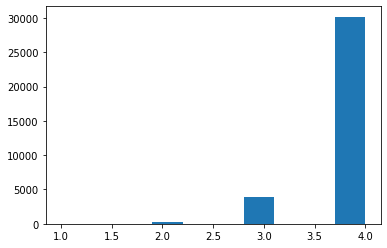

In [12]:
print(neighbours2)

plt.hist(np.sum(neighbours2!=-1,axis=1))

In [6]:
    
for i in range(self.n_cells):
    # get corners
    cell_xi,cell_yi,cell_zi = self.global_index_to_cell_index([i]) 
    
    if cell_xi % 2 == 0:
        tetras = global_index[:,self.tetra_mask_even]
    else:
        tetras = global_index[:,self.tetra_mask]

#             [0,4,5,3],
#               [4,6,7,5],
#               [0,1,6,4],
#               [0,6,5,4],
#               [0,6,5,2]]
    for j in range(5):
        # first tetra in mask is the centre one so its neighbours are the other ones
        if j == 0:
            neighbours[i*5+j,:] = i*5+np.arange(1,5)
            continue
        # add he centre cell to all others
        neighbours[i*5+j,0] = i*5
        if j == 1:
            pass
        if j == 2:
            pass
        if j == 3:
            pass
        if j == 4:
            pass
return neighbours

5

In [7]:
c

NameError: name 'c' is not defined

In [ ]:
points = np.random.random((1000000,3))

In [ ]:
#%%snakeviz
c = mesh.get_tetra(points)

In [ ]:
print(c[1][100])

In [ ]:
from LoopStructural.supports import TetMesh

In [ ]:
boundary_points = np.array([[0,0,0],[1,1,1]])
tmesh = TetMesh()
tmesh.setup_mesh(boundary_points,n_tetra = 200000)

In [ ]:
tmesh.elements_for_array(points)

In [92]:
corners = np.array([[0, 1, 0, 0, 1, 0, 1, 1],
                    [0, 0, 1, 0, 0, 1, 1, 1],
                    [0, 0, 0, 1, 1, 1, 0, 1]])
ni = 3
nj = 3
nk = 3
def gi(i,j,k):
    return i+j*(ni+i)+k*(ni+1)*(nj+1)
i = np.arange(0,ni).astype(int)
j = np.arange(0,nj).astype(int)
k = np.arange(0,nk).astype(int)
ii,jj, kk = np.meshgrid(i,j,k,indexing='ij')
iii = ii[:,:,:,None]+corners[None,None,None,0,:]
jjj = jj[:,:,:,None]+corners[None,None,None,1,:]
kkk = kk[:,:,:,None]+corners[None,None,None,2,:]
corner_gi = gi(iii,jjj,kkk)
corner_gi_flat = gi(iii,jjj,kkk)
corner_gi = corner_gi.reshape(ni*nj*nk,8)


tetra = np.vstack([corner_gi[:,[4,6,7,5]],
                    corner_gi[:,[0,1,6,4]],
                    corner_gi[:,[0,6,5,4]],
                    corner_gi[:,[0,6,5,2]],
                    corner_gi[:,[0,4,5,3]],
                    ])

In [112]:
neighbours = np.zeros((tetra.shape[0],5)).astype(int)
neighbours[:] = -1

In [113]:
build_neighbours(tetra,neighbours)

In [116]:
60%5

0

In [114]:
neighbours[:,4] = np.arange(0,tetra.shape[0])
print(neighbours)

[[ 54  -1  -1  -1   0]
 [ 24  55  -1  -1   1]
 [ 25  56  -1  -1   2]
 [ 57 114  -1  -1   3]
 [ 58 115  -1  -1   4]
 [ 59 116  -1  -1   5]
 [ 33  34  87  88   6]
 [ 34  35  88  89   7]
 [ 35  89 125  -1   8]
 [ 63  -1  -1  -1   9]
 [ 64  -1  -1  -1  10]
 [ 65  -1  -1  -1  11]
 [ 66 129  -1  -1  12]
 [ 67 130  -1  -1  13]
 [ 68 131  -1  -1  14]
 [ 69  -1  -1  -1  15]
 [ 70  -1  -1  -1  16]
 [ 71  -1  -1  -1  17]
 [ 72  -1  -1  -1  18]
 [ 73  -1  -1  -1  19]
 [ 74  -1  -1  -1  20]
 [ 75  -1  -1  -1  21]
 [ 76  -1  -1  -1  22]
 [ 77  -1  -1  -1  23]
 [  1  78  -1  -1  24]
 [  2  79  -1  -1  25]
 [ 80  -1  -1  -1  26]
 [ 54  -1  -1  -1  27]
 [ 55 105  -1  -1  28]
 [ 56 106  -1  -1  29]
 [ 57  -1  -1  -1  30]
 [ 58  -1  -1  -1  31]
 [ 59  -1  -1  -1  32]
 [  6 114  -1  -1  33]
 [  6   7 114 115  34]
 [  7   8 115 116  35]
 [ 63  -1  -1  -1  36]
 [ 64  -1  -1  -1  37]
 [ 65  -1  -1  -1  38]
 [ 66  -1  -1  -1  39]
 [ 67  -1  -1  -1  40]
 [ 68  -1  -1  -1  41]
 [ 69  -1  -1  -1  42]
 [ 70  -1  

In [1]:
from LoopStructural.supports.structured_tetra import TetMesh

In [4]:
origin = np.zeros(3)
steps = np.ones(3)
step_vector = np.zeros(3)
steps[:] = 10
step_vector /= 10
mesh = TetMesh(origin,steps,step_vector)

In [6]:
from LoopStructural.interpolators.piecewiselinear_interpolator import PiecewiseLinearInterpolator as PLI
# from LoopStructural.supports.tet_mesh import TetMesh
from LoopStructural.modelling.features.geological_feature_builder import GeologicalFeatureInterpolator
from LoopStructural.visualisation.model_visualisation import LavaVuModelViewer

In [7]:
import numpy as np
import lavavu
import matplotlib.pyplot as plt
import pandas as pd
import glob
%matplotlib inline

In [10]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = 548800
boundary_points[0,1] = 7816600
boundary_points[0,2] = -11010
boundary_points[1,0] = 552500
boundary_points[1,1] = 7822000
boundary_points[1,2] = -8400
steps[:] = 30
step_vector = boundary_points[1,:] - boundary_points[0,:]
# build the mesh
mesh = TetMesh(boundary_points[0,:],steps,step_vector)
# mesh.setup_mesh(boundary_points, n_tetra=50000,)

# link mesh to the interpolator 
interpolator = PLI(mesh)

AttributeError: 'TetMesh' object has no attribute 'n_nodes'